In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from glob import glob

In [2]:
LABEL_INT_DICT = np.unique(pd.read_csv('ucf11_train_vid.csv')['label'])
LABEL_STR_DICT = {k:v for v, k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_INT_DICT)
pprint(LABEL_STR_DICT)

array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)
{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [3]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

MAX_FRAMES = 10
NUM_FEATURES = 1280

def build_model():
    inputs = keras.Input((MAX_FRAMES, NUM_FEATURES))
    x = keras.layers.LSTM(64, return_sequences=True)(
        inputs
    )
    x = keras.layers.LSTM(64, return_sequences=False)(
        x
    )
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(len(LABEL_INT_DICT),
                                 activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model
    
adam = keras.optimizers.Adam(lr=0.0001)
model = build_model()

model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1280)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            344320    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 11)                715       
Total params: 378,059
Trainable params: 378,059
Non-trainable params: 0
_________________________________________________________________


In [4]:
import albumentations as A
import cv2
import math
import tensorflow as tf
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size,
                 mode='train', shuffle=True):
        assert mode in ['train', 'valid']
        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size
        
        self.npy_paths = glob(
            f'UCF11_updated_npy/{mode}/*.npy'
        )

    def __len__(self):
        return math.ceil(len(self.npy_paths) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.npy_paths[strt:fin]
    
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for npy_path in data:
            npy = np.load(npy_path)
            
            label = npy_path.split('/')[-1]. \
                 split('_')[0]
            label = LABEL_STR_DICT[label]
                 
            batch_x.append(npy)
            batch_y.append(label)
        
        return batch_x, batch_y
                     
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.npy_paths)
            
train_generator = DataGenerator(
    mode='train',
    batch_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    mode='valid',
    batch_size=128,
    shuffle=True)

In [5]:
for x, y in train_generator:
    print(x.shape)
    print(y.shape)
    break

(128, 10, 1280)
(128,)


In [6]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    verbose=1,
)

Epoch 1/30
2/2 [==============================] - 1s 352ms/step - loss: 2.4018 - accuracy: 0.1136 - val_loss: 2.3698 - val_accuracy: 0.0727
Epoch 2/30
2/2 [==============================] - 0s 67ms/step - loss: 2.3538 - accuracy: 0.1864 - val_loss: 2.3189 - val_accuracy: 0.1273
Epoch 3/30
2/2 [==============================] - 0s 58ms/step - loss: 2.2757 - accuracy: 0.2227 - val_loss: 2.2688 - val_accuracy: 0.1818
Epoch 4/30
2/2 [==============================] - 0s 58ms/step - loss: 2.2243 - accuracy: 0.3227 - val_loss: 2.2199 - val_accuracy: 0.2545
Epoch 5/30
2/2 [==============================] - 0s 69ms/step - loss: 2.1488 - accuracy: 0.4773 - val_loss: 2.1717 - val_accuracy: 0.5273
Epoch 6/30
2/2 [==============================] - 0s 63ms/step - loss: 2.0965 - accuracy: 0.5364 - val_loss: 2.1238 - val_accuracy: 0.6182
Epoch 7/30
2/2 [==============================] - 0s 77ms/step - loss: 2.0262 - accuracy: 0.6727 - val_loss: 2.0764 - val_accuracy: 0.6364
Epoch 8/30
2/2 [==========

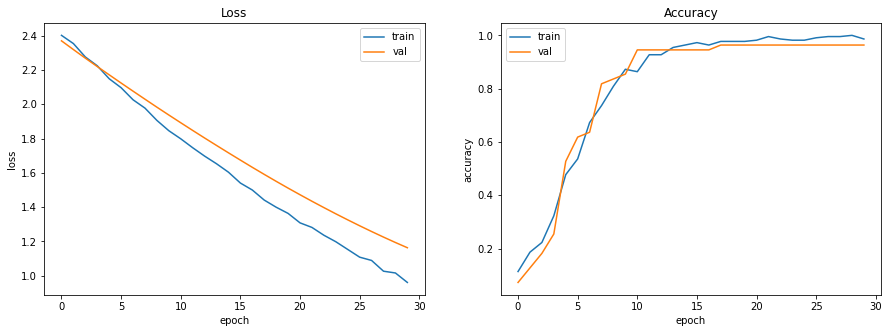

In [7]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()